import itertools
import os
import re
import pickle
import platform
import time
import warnings

from functools import partial
from os.path import abspath, relpath, exists, join

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from matplotlib import pyplot as plt

from IPython import sys_info
from IPython.display import display, HTML, Image, Javascript, Markdown, SVG
from rsmtool.reader import DataReader
from rsmtool.writer import DataWriter
from rsmtool.utils import (float_format_func,
                           int_or_float_format_func,
                           compute_subgroup_plot_params,
                           parse_json_with_comments,
                           bold_highlighter,
                           color_highlighter,
                           show_thumbnail)

from rsmtool.version import VERSION as rsmtool_version

with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=FutureWarning)
    import statsmodels.api as sm

sns.set_context('notebook')

rsm_report_dir = '../../test_outputs/lr-subgroups-with-edge-cases/report/'
if rsm_report_dir is None:
    rsm_report_dir = os.getcwd()

rsm_environ_config = join(rsm_report_dir, '.environ.json')
if not exists(rsm_environ_config):
    raise FileNotFoundError('The file {} cannot be located. '
                            'Please make sure that either (1) '
                            'you have set the correct directory with the `RSM_REPORT_DIR` '
                            'environment variable, or (2) that your `.environ.json` '
                            'file is in the same directory as your notebook.'.format(rsm_environ_config))
    
environ_config = parse_json_with_comments(rsm_environ_config)

# initialize counter for thumbnail IDs
id_generator = itertools.count(1)

# NOTE: you will need to set the following manually
# if you are using this notebook interactively.
experiment_id = environ_config.get('EXPERIMENT_ID')
description = environ_config.get('DESCRIPTION')
context = environ_config.get('CONTEXT')
train_file_location = environ_config.get('TRAIN_FILE_LOCATION')
test_file_location = environ_config.get('TEST_FILE_LOCATION')
output_dir = environ_config.get('OUTPUT_DIR')
figure_dir = environ_config.get('FIGURE_DIR')
model_name = environ_config.get('MODEL_NAME')
model_type = environ_config.get('MODEL_TYPE')
skll_objective = environ_config.get('SKLL_OBJECTIVE')
file_format = environ_config.get('FILE_FORMAT')
length_column = environ_config.get('LENGTH_COLUMN')
second_human_score_column = environ_config.get('H2_COLUMN')
use_scaled_predictions = environ_config.get('SCALED')
min_score = environ_config.get("MIN_SCORE")
max_score = environ_config.get("MAX_SCORE")
standardize_features = environ_config.get('STANDARDIZE_FEATURES')
exclude_zero_scores = environ_config.get('EXCLUDE_ZEROS')
feature_subset_file = environ_config.get('FEATURE_SUBSET_FILE', ' ')
min_items = environ_config.get('MIN_ITEMS')
use_thumbnails = environ_config.get('USE_THUMBNAILS')
predict_expected_scores = environ_config.get('PREDICT_EXPECTED_SCORES')

# groups for analysis by prompt or subgroup.
groups_desc = environ_config.get('GROUPS_FOR_DESCRIPTIVES') 
groups_eval = environ_config.get('GROUPS_FOR_EVALUATIONS') 

# javascript path
javascript_path = environ_config.get("JAVASCRIPT_PATH")

# Read in the training and testing features, both raw and pre-processed
# Make sure that the `spkitemid` and `candidate` columns are read as strings 
# to preserve any leading zeros
# We filter DtypeWarnings that pop up mostly in very large files

string_columns = ['spkitemid', 'candidate']
converter_dict = {column: str for column in string_columns}

with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=pd.io.common.DtypeWarning)
    if exists(train_file_location):
        df_train_orig = DataReader.read_from_file(train_file_location)

    train_file = join(output_dir, '{}_train_features.{}'.format(experiment_id,
                                                                file_format))
    if exists(train_file):
        df_train = DataReader.read_from_file(train_file, converters=converter_dict)

    train_metadata_file = join(output_dir, '{}_train_metadata.{}'.format(experiment_id,
                                                                         file_format))    
    if exists(train_metadata_file):
        df_train_metadata = DataReader.read_from_file(train_metadata_file, converters=converter_dict)

    train_other_columns_file = join(output_dir, '{}_train_other_columns.{}'.format(experiment_id,
                                                                                   file_format))
    if exists(train_other_columns_file):
        df_train_other_columns = DataReader.read_from_file(train_other_columns_file, converters=converter_dict)

    train_length_file = join(output_dir, '{}_train_response_lengths.{}'.format(experiment_id,
                                                                               file_format))
    if exists(train_length_file):
        df_train_length = DataReader.read_from_file(train_length_file, converters=converter_dict)

    train_excluded_file = join(output_dir, '{}_train_excluded_responses.{}'.format(experiment_id,
                                                                                   file_format))
    if exists(train_excluded_file):
        df_train_excluded = DataReader.read_from_file(train_excluded_file, converters=converter_dict)

    train_responses_with_excluded_flags_file = join(output_dir, '{}_train_responses_with_excluded_flags.{}'.format(experiment_id,
                                                                                                                   file_format))
    if exists(train_responses_with_excluded_flags_file):
        df_train_responses_with_excluded_flags = DataReader.read_from_file(train_responses_with_excluded_flags_file,
                                                                           converters=converter_dict)

    train_preproc_file = join(output_dir, '{}_train_preprocessed_features.{}'.format(experiment_id,
                                                                                     file_format))    
    if exists(train_preproc_file):
        df_train_preproc = DataReader.read_from_file(train_preproc_file, converters=converter_dict)

    if exists(test_file_location):
        df_test_orig = DataReader.read_from_file(test_file_location)

    test_file = join(output_dir, '{}_test_features.{}'.format(experiment_id,
                                                              file_format))
    if exists(test_file):
        df_test = DataReader.read_from_file(test_file, converters=converter_dict)

    test_metadata_file = join(output_dir, '{}_test_metadata.{}'.format(experiment_id,
                                                                       file_format))    
    if exists(test_metadata_file):
        df_test_metadata = DataReader.read_from_file(test_metadata_file, converters=converter_dict)

    test_other_columns_file = join(output_dir, '{}_test_other_columns.{}'.format(experiment_id,
                                                                                 file_format))
    if exists(test_other_columns_file):
        df_test_other_columns = DataReader.read_from_file(test_other_columns_file, converters=converter_dict)

    test_human_scores_file = join(output_dir, '{}_test_human_scores.{}'.format(experiment_id,
                                                                               file_format))
    if exists(test_human_scores_file):
        df_test_human_scores = DataReader.read_from_file(test_human_scores_file, converters=converter_dict)

    test_excluded_file = join(output_dir, '{}_test_excluded_responses.{}'.format(experiment_id,
                                                                                 file_format))
    if exists(test_excluded_file):
        df_test_excluded = DataReader.read_from_file(test_excluded_file, converters=converter_dict)

    test_responses_with_excluded_flags_file = join(output_dir, '{}_test_responses_with_excluded_flags.{}'.format(experiment_id,
                                                                                                                 file_format))
    if exists(test_responses_with_excluded_flags_file):
        df_test_responses_with_excluded_flags = DataReader.read_from_file(test_responses_with_excluded_flags_file,
                                                                          converters=converter_dict)

    test_preproc_file = join(output_dir, '{}_test_preprocessed_features.{}'.format(experiment_id,
                                                                                   file_format))
    if exists(test_preproc_file):
        df_test_preproc = DataReader.read_from_file(test_preproc_file, converters=converter_dict)

    pred_preproc_file = join(output_dir, '{}_pred_processed.{}'.format(experiment_id,
                                                                       file_format))
    if exists(pred_preproc_file):
        df_pred_preproc = DataReader.read_from_file(pred_preproc_file, converters=converter_dict)

    feature_file = join(output_dir, '{}_feature.{}'.format(experiment_id,
                                                           file_format))
    if exists(feature_file):
        df_features = DataReader.read_from_file(feature_file, converters=converter_dict)
        features_used = [c for c in df_features.feature.values]

    betas_file = join(output_dir, '{}_betas.{}'.format(experiment_id,
                                                       file_format))
    if exists(betas_file):
        df_betas = DataReader.read_from_file(betas_file)

    if exists(feature_subset_file):
        df_feature_subset_specs = DataReader.read_from_file(feature_subset_file)
    else:
        df_feature_subset_specs = None

## Additional fairness analyses

This section presents additional fairness analyses described in detail in [Loukina et al. (2019)](www.aclweb.org).
These analyses consider separately different definitions of fairness and can assist in further trouble-shooting 
the observed subgroup differences. The evaluations focuses on three dimensions:

* **Outcome fairness** measures:  

    - *Overall score accuracy*: whether automated scores are equally accurate for each group. The metric shows how much of variance in squared error $(S-H)^2$ is explained by subgroup membership.

    -  *Overall score difference*: whether automated scores are consistently different from human scores for members of a certain group. The metric shows how much of variance in actual error $S-H$ is explained by subgroup membership. 

The differences in the outcome fairness measures might be due to both different mean score (different score distribution) between the subgroups and differential treatment of different subgroups by the scoring engine. 

* **Process fairness** measures:

    - *Conditional score difference*: whether automated scoring engines assign different scores to speakers from different groups despite their having the same language proficiency. The metric shows how much additional variance in actual error ($S-H$) is explained by subgroup membership after controlling for human proficiency score. 

The differences in process fairness measures indicate differential treatment of different subgroups by the scoring engine.

In [6]:
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

from rsmtool.writer import DataWriter
from rsmtool.container import DataContainer


def convert_to_category(group_values):
    groups_by_size = group_values.value_counts().index
    group_category = group_values.astype("category")
    group_ordered_category = group_category.cat.reorder_categories(groups_by_size,
                                                                   ordered=True)
    return group_ordered_category
    

def get_coefficients(res,
                     base_category):
        
    df_results = pd.concat([res.params, res.pvalues, res.conf_int()], axis=1)
        
    df_results.columns = ['estimate', 'P>[t]', '[0.025', '0.975]']
        
    groups = ['Intercept'] + [v for v in df_results.index if 'group' in v]
        
    df_results = df_results.loc[groups]
        
    df_results.index = [v.split('.')[1].strip(']') 
                            if not v == 'Intercept' 
                            else 'Intercept ({})'.format(base_category)
                            for v in df_results.index]
        
    return df_results


def write_fairness_results(fit_dictionary,
                           fairness_container,
                           group,
                           output_dir,
                           experiment_id, 
                           file_format):
    
    # save model summary
    for model in fit_dictionary:
        ols_file = join(output_dir, '{}_{}_by_{}.ols'.format(experiment_id,
                                                             fairness_metrics,
                                                             group))
        summary_file = join(output_dir, '{}_{}_by_{}_ols_summary.txt'.format(experiment_id,
                                                                             fairness_metrics,
                                                                             group))
        with open(ols_file, 'wb') as olsf, open(summary_file, 'w') as summf:
            pickle.dump(fit, olsf)
            summf.write(str(fit.summary()))
            
    writer = DataWriter(experiment_id)
    
    writer.write_experiment_output(output_dir,
                                   fairness_container,
                                   file_format=file_format)

    
    
def get_fairness_analysis(df,
                          group,
                          system_score_column,
                          human_score_column='sc1'):
    ''' Main function for computing various fairness metrics'''
    
    # compute error and squared error

    df['error'] = df['raw_trim']-df['sc1']
    df['SE'] = df['error']**2

    # convert group values to category and reorder them using 
    # the largest category as reference
    
    df['group'] = convert_to_category(df[group])
    base_group = df['group'].cat.categories[0]
    df['sc1_cat'] = convert_to_category(df['sc1'])

    # compute error and squared error

    df['error'] = df['raw_trim']-df['sc1']
    df['SE'] = df['error']**2

    # convert group values to category and reorder them using 
    # the largest category as reference
    
    df['group'] = convert_to_category(df[group])
    base_group = df['group'].cat.categories[0]
    df['sc1_cat'] = convert_to_category(df['sc1'])

    # Overall score accuracy (OSA)
    # Variance in squared error explained by L1
    
    osa_model = smf.ols(formula='SE ~ group', data=df)
    osa_fit = osa_model.fit()
    
    osa_dict = {'R2': osa_fit.rsquared_adj,
               'sig': osa_fit.f_pvalue}

    osa_results = pd.Series(osa_dict, name='Overall score accuracy')

    df_coefficients_osa = get_coefficients(osa_fit, base_group)

    # Overall score difference (OSD)
    # variance in signed residuals (raw error) explained by L1

    osd_model = smf.ols(formula='error ~ group', data=df)
    osd_fit = osd_model.fit()
    
    osd_dict = {'R2': osd_fit.rsquared_adj,
               'sig': osd_fit.f_pvalue}

    osd_results = pd.Series(osd_dict, name='Overall score difference')

    df_coefficients_osd = get_coefficients(osd_fit, base_group)
    
    # conditional score difference CSD 
    # Variance in score difference conditioned on Native language
    
    csd_null_mod = smf.ols(formula='error ~ sc1_cat', data=df)
    csd_null_fit = csd_null_mod.fit()
    csd_mod = smf.ols(formula='error ~ group + sc1_cat', data=df)
    csd_fit = csd_mod.fit()

    # we filter warnings for this function because we get 
    # runtime warning due to NaNs in the data.
    # these seem to be by design: https://groups.google.com/forum/#!topic/pystatsmodels/-flY0cNnb3k
    np.warnings.filterwarnings('ignore')
    anova_results = anova_lm(csd_null_fit, csd_fit)
    # we reset warnings
    np.warnings.resetwarnings()
    
    csd_dict = {'R2': csd_fit.rsquared_adj - csd_null_fit.rsquared_adj,
               'sig': anova_results.values[1][-1]}
    csd_results = pd.Series(csd_dict, name='Conditional score difference')

    df_coefficients_csd = get_coefficients(osd_fit, base_group)

    df_r2_all = pd.concat([osa_results, osd_results, csd_results], axis=1, sort=True)
    df_r2_all['base_category'] = base_group
    
    datasets = [{'name': 'estimates_osa_by_{}'.format(group),
                 'frame': df_coefficients_osa},
                {'name': 'estimates_osd_by_{}'.format(group),
                 'frame': df_coefficients_osd},
                {'name': 'estimates_csd_by_{}'.format(group),
                 'frame': df_coefficients_csd},
                {'name': 'fairness_metrics_by_{}'.format(group),
                 'frame': df_r2_all}]
    
    model_dict = {'osa': osa_fit,
                  'osd': osd_fit,
                  'csd': csd_fit}
    
    return model_dict, DataContainer(datasets=datasets)
    
    
    
    

In [7]:
 def errplot(x, y, xerr, **kwargs):
    ax = plt.gca()
    data = kwargs.pop("data")
    # let's remove color from kwargs
    color = kwargs.pop('color')
    data.plot(x=x, y=y, xerr=xerr,
              kind="barh", ax=ax,
              color=colors,
              **kwargs)


### group_edge_cases

The summary table shows the overall score accuracy (OSA), overall score difference (OSD) and conditional score difference (CSD). The first row reports the percentage of variance, the second row shows $p$ value. NormalGroup was used as a reference category. Larger values of R2 indicate larger differences between subgroupsFurther detail about each model can be found in intermediate output files

,Overall score accuracy,Overall score difference,Conditional score difference
R2,0.523,0.546,0.074
sig,0.000,0.000,0.000


The plots show error estimates for different categories for each group. (squared error for OSA, absolute error for OSD, and conditional error for CSD) The estimates have been adjusted for InterceptBlack lines show 95% confidence intervals estimated by the model.

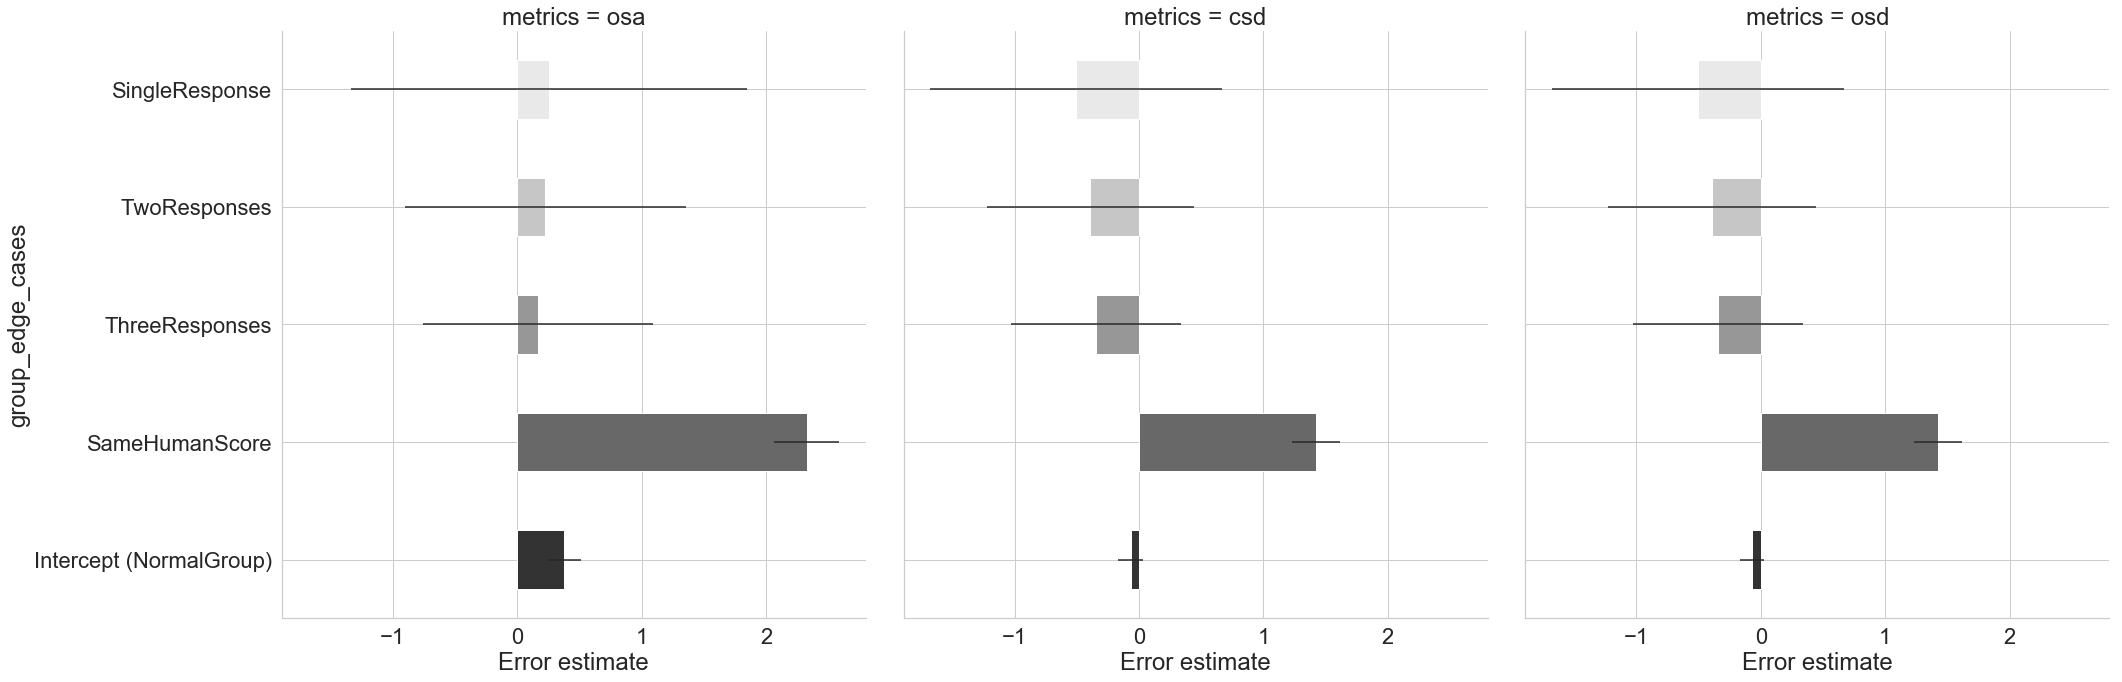

The plot shows average scale_trim system score for each group conditioned on human score

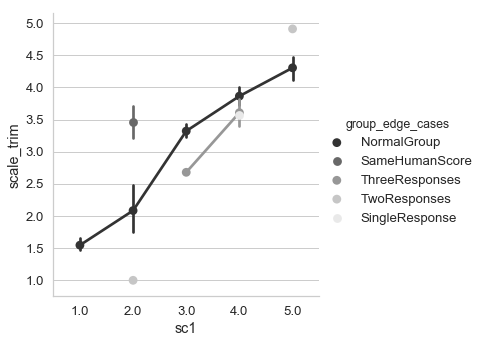

In [8]:
# check if we already created the merged file in another notebook

try:
    df_pred_preproc_merged
except NameError:
    df_pred_preproc_merged = pd.merge(df_pred_preproc, df_test_metadata, on = 'spkitemid')
    

system_score_column = "scale_trim" if use_scaled_predictions else "raw_trim"

for group in groups_eval:
    
    display(Markdown("### {}".format(group)))
    
    fit_dict, fairness_container = get_fairness_analysis(df_pred_preproc_merged,
                                                         group,
                                                         system_score_column)
    
    df_fairness = fairness_container['fairness_metrics_by_{}'.format(group)]
    
    display(Markdown("The summary table shows the overall score accuracy (OSA), overall score difference (OSD) "
                    "and conditional score difference (CSD). The first row reports the percentage of variance, "
                    "the second row shows $p$ value. {} was used as a reference category. "
                    "Larger values of R2 indicate larger differences between subgroups" 
                    "Further detail about each model can be found in intermediate "
                    "output files".format(df_fairness['base_category'].values[0])))
    
    display(HTML(df_fairness.loc[['R2', 'sig'],
                                 ['Overall score accuracy',
                                  'Overall score difference',
                                  'Conditional score difference']].to_html(classes='sortable',
                                                                     float_format=float_format_func)))
    # show coefficient plots
    groups_by_size = df_pred_preproc_merged[group].value_counts().index
    colors = sns.color_palette("Greys_r", len(groups_by_size))

    
    display(Markdown("The plots show error estimates for different categories for each group. "
                     "(squared error for OSA, absolute error for OSD, and conditional error for CSD) "
                     "The estimates have been adjusted for Intercept"
                     "Black lines show 95% confidence intervals estimated by the model."))
   
    
    all_coefs = []
    for metrics in ['osa', 'csd', 'osd']:
        df_metrics = fairness_container['estimates_{}_by_{}'.format(metrics, group)].copy()
        non_index_cols = [r for r in df_metrics.index if not "Intercept" in r]
        index_col = [r for r in df_metrics.index if "Intercept" in r]
        df_metrics['error_estimate'] = df_metrics['estimate']
        df_metrics.loc[non_index_cols,
                      'error_estimate'] = df_metrics.loc[non_index_cols,
                                                        'estimate'] + df_metrics.loc[index_col,
                                                                                    'estimate'].values
        df_metrics['metrics'] = metrics
        all_coefs.append(df_metrics)

    df_coefs_all = pd.concat(all_coefs)
    df_coefs_all[group] = df_coefs_all.index
    df_coefs_all['CI'] = df_coefs_all['[0.025'] - df_coefs_all['estimate']

    with sns.axes_style('whitegrid'), sns.plotting_context('notebook', font_scale=2):
        g = sns.FacetGrid(df_coefs_all, col="metrics",
                          height=10)
        g.map_dataframe(errplot, group, "error_estimate",  "CI").set_axis_labels("Error estimate",
                                                                                group)

        imgfile = join(figure_dir, '{}_fairness_estimates_{}.svg'.format(experiment_id, group))
        plt.savefig(imgfile)
        if use_thumbnails:
            show_thumbnail(imgfile, next(id_generator))
        else:
            plt.show()
    
    
    # show the plots
    display(Markdown("The plot shows average {} system score for each group conditioned "
                     "on human score".format(system_score_column)))
    
    with sns.axes_style('whitegrid'), sns.plotting_context('notebook', font_scale=1.2):
        p = sns.catplot(x='sc1', y=system_score_column,
                            hue=group, 
                            hue_order = groups_by_size,
                            palette=colors,
                            legend_out=True,
                            kind="point",
                            data=df_pred_preproc_merged)

        #plt.tight_layout(h_pad=1.0)
        imgfile = join(figure_dir, '{}_conditional_score_{}.svg'.format(experiment_id, group))
        plt.savefig(imgfile)
        if use_thumbnails:
            show_thumbnail(imgfile, next(id_generator))
        else:
            plt.show()
            